### Ellipse Detection (Custom Method)
Inspired by Random Seeding Algorithm

Import Image, Downsize Image:

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg

In [2]:
from early_analysis import *

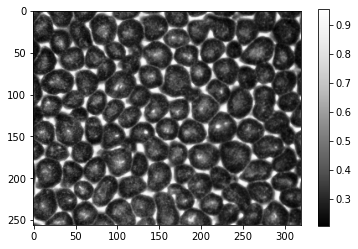

In [11]:
source_dir = "/Users/johnmays/Documents/Wirth Lab/convection-cell-research/data/LCB6mil90deg0_frames"
os.chdir(source_dir)
frame1 = mpimg.imread('frame1.png')
frame1 = frame1[...,0] # convert to 1D grayscale
height, width = np.shape(frame1)
downsized_frame1 = cv.resize(frame1, (int(width/4), int(height/4)), cv.INTER_AREA)
plt.imshow(downsized_frame1, cmap='Greys_r')
plt.colorbar();

##### Algorithm:
Steps:
1. Set max radius and min radius parameters
2. Have a function that scans pixels of a desired radius
3. Give padding of max radius to image
4. For every pixel in image, track mean intensity per pixel within ring (count up w/ radii) -> take |maximum shift| over |mean shift| and that is the intensity (representative of likelihood for particle centroid) for selected pixel in image
6. Normalize intensity values
7. Process to highlight local maxima


In [52]:
max_radius = 25
min_radius = 5

In [53]:
# I want a function that pre-generates the (x,y) list of xy lists for circles and then one that checks using those lists

In [54]:
def generaterastercirclecoords(radius):
    coordinate_pairs = []
    x = radius
    y = 0
    P = 1-radius
    coordinate_pairs.append((x,y))
    coordinate_pairs.append((-x,y))
    coordinate_pairs.append((-x,-y))
    coordinate_pairs.append((x,-y))
    coordinate_pairs.append((y,x))
    coordinate_pairs.append((y,-x))
    coordinate_pairs.append((-y,-x))
    coordinate_pairs.append((-y,x))
    while x > y:
        y += 1
        if P <= 0:
            P = P + 2*y + 1
        else:
            x -= 1
            P = P + 2*y -2*x + 1
        coordinate_pairs.append((x,y))
        coordinate_pairs.append((-x,y))
        coordinate_pairs.append((-x,-y))
        coordinate_pairs.append((x,-y))
        coordinate_pairs.append((y,x))
        coordinate_pairs.append((y,-x))
        coordinate_pairs.append((-y,-x))
        coordinate_pairs.append((-y,x))
    return list(set(coordinate_pairs))

In [60]:
# okay, now I want to make a coordinate set for all radii:
radii = list(range(min_radius, max_radius+1))
circle_coordinates = []
for radius in radii:
    circle_coordinates.append(generaterastercirclecoords(radius))

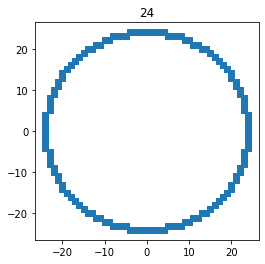

In [71]:
# proving that it works
plt.figure(figsize=(4,4))
plt.scatter(*zip(*circle_coordinates[19]), marker="s")
plt.title(radii[19])
plt.show()

In [97]:
# now, I want a function obtains a relationship between the average intensity over radii
def getradialintensityfunction(image, center): #radii, circle_coordinates
    intensities = np.zeros(len(radii))
    for i in range(len(radii)):
        sum_intensities = 0
        for coordinate in circle_coordinates[i]:
            sum_intensities += image[center[0]+coordinate[0], center[1]+coordinate[1]]
        intensities[i] = sum_intensities/len(circle_coordinates[i]) # (average per pixel)
    return intensities

Text(0.5, 1.0, 'Image with test coordinate and radial area covered')

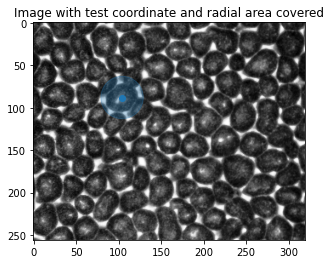

In [98]:
# pick a coordinate:
test_coordinate = (104, 88)
fig, axs = plt.subplots()
plt.imshow(downsized_frame1, cmap='Greys_r')
plt.scatter([test_coordinate[0]], [test_coordinate[1]]);
axs.add_patch(plt.Circle(test_coordinate, max_radius, color='tab:blue', alpha=0.3));
plt.title("Image with test coordinate and radial area covered")

In [99]:
intensities = getradialintensityfunction(downsized_frame1, test_coordinate)

In [100]:
len(radii)

21

In [101]:
len(intensities)

21

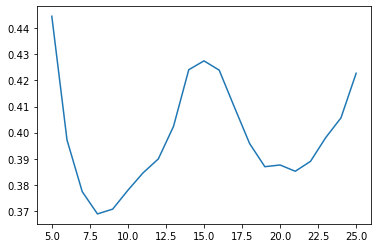

In [103]:
plt.plot(radii, intensities)

This is promising; I was hoping to see a big local maxima in the center.

A quick way to get that maxima in the center would be to only accept maxima with a lower value on each side.  Probably not foolproof though; I may have to cut data out and then do that.

In [105]:
def getintensitydifferences(intensities): # essentially a kind of discrete derivative
    intensity_differences = np.zeros(len(intensities)-1)
    for i in range(len(intensity_differences)):
        intensity_differences[i] = intensities[i+1] - intensities[i]
    return intensity_differences

In [106]:
intensity_differences = getintensitydifferences(intensities)

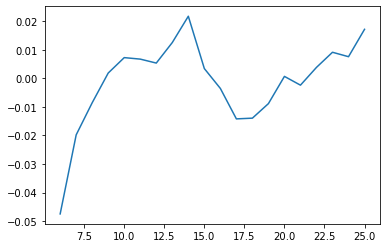

In [109]:
plt.plot(radii[1:], intensity_differences);

Weird.  This one is not so clear.  But it does have an obvious maxima.

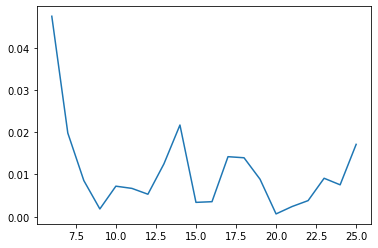

In [110]:
plt.plot(radii[1:], np.abs(intensity_differences));

Probably should check this on a cleaner image.